In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.stats import zscore, linregress
from pandas.plotting import scatter_matrix
from scipy import stats
import numpy as np
import seaborn as sns

In [2]:
# # Function to remove outliers from a dataframe
# from sklearn.neighbors import LocalOutlierFactor


# def remove_outliers(df):
#     # Initialize a boolean mask to keep track of rows to drop
#     outlier_rows_mask = np.zeros(len(df), dtype=bool)

#     # Iterate over each column
#     for col in df.columns:
#         # Skip the "t1" and "t2" columns
#         if col == "t1" or col == "t2":
#             continue

#         # Fit the LocalOutlierFactor model to the column data
#         lof = LocalOutlierFactor()
#         outliers = lof.fit_predict(df[col].values.reshape(-1, 1))

#         # Mark rows with outliers in this column
#         outlier_rows_mask = np.logical_or(outlier_rows_mask, outliers == -1)

#     # Drop rows with outliers
#     cleaned_df = df[~outlier_rows_mask]
#     return cleaned_df


def remove_outliers(df, threshold=2):
    # Initialize a boolean mask to keep track of rows to drop
    outlier_rows_mask = np.zeros(len(df), dtype=bool)

    # Iterate over each column
    for col in df.columns:
        # Skip the "t1" and "t2" columns
        if col == "t1" or col == "t2":
            continue

        # Calculate the mean and standard deviation of the column
        mean = df[col].mean()
        std = df[col].std()

        # Find outliers in this column
        outliers = (df[col] - mean).abs() > threshold * std

        # Mark rows with outliers in this column
        outlier_rows_mask = np.logical_or(outlier_rows_mask, outliers)

    # Drop rows with outliers
    cleaned_df = df[~outlier_rows_mask]
    return cleaned_df

In [3]:
fluxnet_info = pd.read_csv("../data/EC/fluxnet/sites_info.csv")
ameriflux_info = pd.read_csv("../data/EC/Ameriflux/sites_info.tsv", delimiter="\t")
fluxnet_names = fluxnet_info["ID"].to_list()
fluxnet_types = fluxnet_info["type"].to_list()
ameriflux_names = ameriflux_info["Site ID"].to_list()
ameriflux_types = ameriflux_info["Vegetation Abbreviation (IGBP)"].to_list()

In [4]:
combined_names = list(set(ameriflux_names + fluxnet_names))
combined_types = []
for name in combined_names:
    if name in ameriflux_names and name in fluxnet_names:
        # Choose a type from either fluxnet_types or ameriflux_types
        combined_types.append(fluxnet_types[fluxnet_names.index(name)])
    elif name in ameriflux_names:
        combined_types.append(ameriflux_types[ameriflux_names.index(name)])
    else:
        combined_types.append(fluxnet_types[fluxnet_names.index(name)])

In [5]:
dfs = []

# Iterate over the range of length of 'name' column in sites_info
for i in range(len(combined_names)):
    site_name = combined_names[i]
    site_type = combined_types[i]

    # Set the file path based on whether the combined name is in ameriflux_names or fluxnet_names
    if site_name in ameriflux_names:
        file = glob.glob("../data/EC/Ameriflux/AMF_" + site_name + "*WW*")
    else:
        file = glob.glob("../data/EC/fluxnet/FLX_" + site_name + "*WW*")

    # Open the CSV file
    ec = pd.read_csv(file[0])
    ec.loc[:, "type"] = site_type
    ec.loc[:, "name"] = site_name

    ec["t1"] = pd.to_datetime(ec["TIMESTAMP_START"], format="%Y%m%d")
    ec["t2"] = pd.to_datetime(ec["TIMESTAMP_END"], format="%Y%m%d")

    # Append the DataFrame to the list
    dfs.append(ec)

# Concatenate all DataFrames in the list
combined_ec = pd.concat(dfs)

In [6]:
MCD43_fluxnet = []
MCD15_fluxnet = []
MCD43_ameriflux = []
MCD15_ameriflux = []

# Loop over batches (#5) of downloaded data
for i in range(1, 5):
    refl_fluxnet = glob.glob(
        "../data/EC/fluxnet/sat_data/*batch" + str(i) + "*MCD43A4-061-results.csv"
    )
    sat_refl_fluxnet = pd.read_csv(refl_fluxnet[0])
    sat_refl_fluxnet.loc[:, "time"] = pd.to_datetime(sat_refl_fluxnet["Date"])
    sat_refl_fluxnet.set_index(sat_refl_fluxnet["Date"], inplace=True)
    MCD43_fluxnet.append(sat_refl_fluxnet)

    fpar_fluxnet = glob.glob(
        "../data/EC/fluxnet/sat_data/*batch" + str(i) + "*MCD15A3H-061-results.csv"
    )
    sat_fpar_fluxnet = pd.read_csv(fpar_fluxnet[0])
    sat_fpar_fluxnet.loc[:, "time"] = pd.to_datetime(sat_fpar_fluxnet["Date"])
    sat_fpar_fluxnet.set_index(sat_fpar_fluxnet["Date"], inplace=True)
    MCD15_fluxnet.append(sat_fpar_fluxnet)

    if i < 5:
        refl_ameriflux = glob.glob(
            "../data/EC/Ameriflux/sat_data/*batch" + str(i) + "*MCD43A4-061-results.csv"
        )

        sat_refl_ameriflux = pd.read_csv(refl_ameriflux[0])
        sat_refl_ameriflux.loc[:, "time"] = pd.to_datetime(sat_refl_ameriflux["Date"])
        sat_refl_ameriflux.set_index(sat_refl_ameriflux["Date"], inplace=True)
        MCD43_ameriflux.append(sat_refl_ameriflux)

        fpar_ameriflux = glob.glob(
            "../data/EC/Ameriflux/sat_data/*batch"
            + str(i)
            + "*MCD15A3H-061-results.csv"
        )
        fpar_ameriflux = pd.read_csv(fpar_ameriflux[0])

        fpar_ameriflux.loc[:, "time"] = pd.to_datetime(fpar_ameriflux["Date"])
        fpar_ameriflux.set_index(fpar_ameriflux["Date"], inplace=True)
        MCD15_ameriflux.append(fpar_ameriflux)


refl_fluxnet = pd.concat(MCD43_fluxnet)
refl_fluxnet = refl_fluxnet.rename(columns={"ID": "name"})

fpar_fluxnet = pd.concat(MCD15_fluxnet)
fpar_fluxnet = fpar_fluxnet.rename(columns={"ID": "name"})

refl_ameriflux = pd.concat(MCD43_ameriflux)
refl_ameriflux = refl_ameriflux.rename(columns={"ID": "name"})
fpar_ameriflux = pd.concat(MCD15_ameriflux)
fpar_ameriflux = fpar_ameriflux.rename(columns={"ID": "name"})
combined_refl = []
combined_fpar = []

for name in combined_names:
    if name in ameriflux_names:
        selected_refl = refl_ameriflux[refl_ameriflux["name"] == name]
        selected_fpar = fpar_ameriflux[fpar_ameriflux["name"] == name]
    else:
        selected_refl = refl_fluxnet[refl_fluxnet["name"] == name]
        selected_fpar = fpar_fluxnet[fpar_fluxnet["name"] == name]

    combined_refl.append(selected_refl)
    combined_fpar.append(selected_fpar)

combined_refl = pd.concat(combined_refl)
combined_fpar = pd.concat(combined_fpar)

In [7]:
bad_sites_list = []
good_sites_list = []


for i in range(len(combined_names)):
    # for i in range(2, 6):
    print(i)
    site_name = combined_names[i]
    site_type = combined_types[i]
    site_ec = combined_ec[combined_ec["name"] == site_name]
    site_refl = combined_refl[combined_refl["name"] == site_name]
    site_fpar = combined_fpar[combined_fpar["name"] == site_name]
    if site_ec["PPFD_IN_QC"].isna().all():
        print("No PPFD data for " + site_name)
        bad_sites_list.append(site_name)
        continue
    gpp = site_ec[["GPP_NT_VUT_REF"]]
    par = site_ec[["PPFD_IN"]]
    par_qc = site_ec[["PPFD_IN_QC"]]
    time1 = site_ec[["t1"]]
    time2 = site_ec[["t2"]]
    ec_weekly = pd.concat([time1, time2, gpp, par, par_qc], axis=1).rename(
        columns={"GPP_NT_VUT_REF": "gpp", "PPFD_IN": "par", "PPFD_IN_QC": "par_qc"}
    )
    ec_weekly = ec_weekly[ec_weekly["par_qc"] == 1]
    ec_weekly = ec_weekly[ec_weekly["gpp"] != -9999]
    ec_weekly.drop(columns=["par_qc"], inplace=True)
    if ec_weekly.empty:
        print("No data for " + site_name)
        bad_sites_list.append(site_name)
        continue

    site_fpar_filtered = site_fpar[
        (site_fpar["MCD15A3H_061_FparLai_QC_MODLAND"] == "0b0")
        & (site_fpar["MCD15A3H_061_FparLai_QC_DeadDetector"] == "0b0")
        & (site_fpar["MCD15A3H_061_FparLai_QC_CloudState"] == "0b00")
        & (site_fpar["MCD15A3H_061_FparLai_QC_SCF_QC"].isin(["0b000", "0b001"]))
    ]
    site_fpar_filtered.index = pd.to_datetime(site_fpar_filtered.index)

    site_refl_filtered = site_refl[
        (
            site_refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band1_MODLAND"]
            == "0b000"
        )
        & (
            site_refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band2_MODLAND"]
            == "0b000"
        )
    ]

    site_refl_filtered.index = pd.to_datetime(site_refl_filtered.index)
    resampled_fpar = []
    resampled_refl = []

    for idx, row in ec_weekly.iterrows():
        # Select the data for the current week
        t1 = pd.to_datetime(row["t1"])
        t2 = pd.to_datetime(row["t2"])
        mask_fpar = (site_fpar_filtered.index >= t1) & (site_fpar_filtered.index <= t2)
        weekly_data_fpar = site_fpar_filtered[mask_fpar]

        mask_refl = (site_refl_filtered.index >= t1) & (site_refl_filtered.index <= t2)
        weekly_data_refl = site_refl_filtered[mask_refl]

        if (weekly_data_fpar.empty) | (weekly_data_refl.empty):
            continue

        red_tmp = weekly_data_refl["MCD43A4_061_Nadir_Reflectance_Band1"].mean()
        nir_tmp = weekly_data_refl["MCD43A4_061_Nadir_Reflectance_Band2"].mean()

        fpar_tmp = weekly_data_fpar["MCD15A3H_061_Fpar_500m"].mean()

        resampled_fpar.append({"t1": t1, "t2": t2, "fpar_mean": fpar_tmp})
        resampled_refl.append({"t1": t1, "t2": t2, "red": red_tmp, "nir": nir_tmp})

    resampled_fpar_df = pd.DataFrame(resampled_fpar)
    resampled_refl_df = pd.DataFrame(resampled_refl)

    if resampled_fpar_df.empty | resampled_refl_df.empty:
        print("No data for " + site_name)
        bad_sites_list.append(site_name)
        continue
    # Select rows from site_ec where t1 and t2 match those in resampled_fpar_df and resampled_refl_df
    mask = (
        ec_weekly["t1"].isin(resampled_fpar_df["t1"])
        & ec_weekly["t2"].isin(resampled_fpar_df["t2"])
    ) | (
        ec_weekly["t1"].isin(resampled_refl_df["t1"])
        & ec_weekly["t2"].isin(resampled_refl_df["t2"])
    )

    resampled_ec_df = ec_weekly[
        mask
    ]  # Note: although called resampled, we dont resample,
    merged_df = pd.merge(
        resampled_fpar_df, resampled_refl_df, how="inner", on=["t1", "t2"]
    )

    # Then merge the result with resampled_ec_df
    site_df = pd.merge(merged_df, resampled_ec_df, how="inner", on=["t1", "t2"]).copy()
    site_df.loc[:, "ndvi"] = (site_df["nir"] - site_df["red"]) / (
        site_df["nir"] + site_df["red"]
    )
    site_df.loc[:, "nirv"] = site_df["ndvi"] * site_df["nir"]
    site_df.loc[:, "nirvp"] = site_df["nirv"] * site_df["par"]
    site_df.loc[:, "fesc"] = site_df["nirv"] / site_df["fpar_mean"]
    site_df.loc[:, "lue"] = site_df["gpp"] / (site_df["par"] * site_df["fpar_mean"])
    cleaned_site_df = remove_outliers(site_df)
    if cleaned_site_df.empty:
        print("No data for " + site_name)
        bad_sites_list.append(site_name)
        continue
    cleaned_site_df = cleaned_site_df.copy()
    cleaned_site_df.loc[:, "site_type"] = site_type
    cleaned_site_df.loc[:, "site_name"] = site_name
    good_sites_list.append(cleaned_site_df)

0
1
2
3
4
5
6
7
No PPFD data for CN-Cha
8
9
10
No data for US-WPT
11
12
13
14
15
16
No PPFD data for CN-Ha2
17
18
No PPFD data for US-CS1
19
No PPFD data for AU-Fog
20
No PPFD data for CN-Qia
21
No PPFD data for CN-Dan
22
23
24
25
26
No PPFD data for AU-Ade
27
No PPFD data for US-Rwe
28
No PPFD data for AU-Cum
29
No data for IT-Ro1
30
31
32
33
34
35
36
No PPFD data for AU-TTE
37
No PPFD data for US-Cop
38
39
40
No PPFD data for AU-How
41
42
43
No PPFD data for AU-Whr
44
No PPFD data for AU-Rig
45
No PPFD data for MX-Tes
46
No data for GL-NuF
47
48
No PPFD data for AU-Tum
49
50
51
52
53
54
55
No PPFD data for AU-RDF
56
57
58
No data for US-KS3
59
60
61
No data for BR-Sa3
62
63
64
65
66
67
68
69
No PPFD data for AU-Wac
70
No PPFD data for CN-Din
71
72
No PPFD data for AU-Dry
73
74
75
76
No data for US-ORv
77
78
79
80
81
82
83
No PPFD data for US-CS4
84
85
86
87
88
89
90
No data for GL-ZaF
91
92
93
94
95
96
No data for US-Wi1
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
11

In [36]:
df = pd.concat(good_sites_list)

0      0.023330
1      0.030215
2      0.033978
3      0.025497
4      0.026875
         ...   
577    0.017064
579    0.006127
580    0.008159
581    0.005644
582   -0.001183
Name: lue, Length: 525, dtype: float64

In [395]:
site_type_mapping = df.drop_duplicates("site_name").set_index("site_name")["site_type"]

# Calculate the median of 'lue' for each 'site_name'
# median_values = df.groupby("site_name")[["lue", "fesc", "nirv", "ndvi", "gpp"]].median()
# # # Add a new column to median_values using this mapping
# median_values["site_type"] = median_values.index.map(site_type_mapping)
# median_values["site_name"] = median_values.index

mean_values = df.groupby("site_name")[["lue", "fesc", "nirv", "ndvi", "gpp"]].mean()
mean_values["site_type"] = mean_values.index.map(site_type_mapping)

site_names = df["site_name"].unique()

max_values = []
median_values = []
# for site_name in site_names:
for i in range(len(site_names)):
    site_tmp = df.groupby("site_name").get_group(site_names[i])["lue"]
    if len(site_tmp) < 30:
        continue
    # Get the rows associated to the maximum value
    index_tmp = site_tmp.idxmax()
    
    median_value = site_tmp.median()
    median_index = (site_tmp - median_value).abs().idxmin()
    median_row = df.groupby("site_name").get_group(site_names[i]).loc[median_index]
    
    max_values.append(df.groupby("site_name").get_group(site_names[i]).loc[index_tmp])
    median_values.append(median_row)


max_values = pd.concat(max_values, axis=1).T
median_values = pd.concat(median_values, axis=1).T
median_values


,t1,t2,fpar_mean,red,nir,gpp,par,ndvi,nirv,nirvp,fesc,lue,site_type,site_name
163,2010-08-27 00:00:00,2010-09-02 00:00:00,0.885,0.026629,0.287557,9.36661,588.201403,0.830492,0.238814,140.470594,0.269846,0.017993,DBF,US-Oho
81,2006-05-28 00:00:00,2006-06-03 00:00:00,0.735,0.032967,0.2548,6.57108,477.765035,0.770879,0.19642,93.842616,0.267238,0.018713,ENF,CA-TP3
58,2005-06-18 00:00:00,2005-06-24 00:00:00,0.445,0.039014,0.195743,3.07207,466.933865,0.66762,0.130682,61.019783,0.293667,0.014785,OSH,CA-SF3
15,2011-06-25 00:00:00,2011-07-01 00:00:00,0.76,0.063471,0.283186,4.36654,474.563264,0.633809,0.179486,85.177247,0.236165,0.012107,ENF,DE-Lkb
17,2003-06-11 00:00:00,2003-06-17 00:00:00,0.6,0.042043,0.2495,4.26114,595.121222,0.711584,0.17754,105.6579,0.2959,0.011934,OSH,CA-NS6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2013-06-11 00:00:00,2013-06-17 00:00:00,0.85,0.0316,0.339043,9.40757,544.100626,0.829485,0.281231,153.018027,0.33086,0.020341,MF,US-Syv
6,2015-07-23 00:00:00,2015-07-29 00:00:00,0.38,0.087557,0.239929,6.1387,657.347486,0.465277,0.111633,73.381765,0.293771,0.024575,CSH,US-Rms
22,2005-07-30 00:00:00,2005-08-05 00:00:00,0.49,0.099086,0.288957,3.12129,344.927083,0.489305,0.141388,48.768641,0.288547,0.018468,CRO,DE-Kli
4,2006-09-10 00:00:00,2006-09-16 00:00:00,0.73,0.052457,0.330571,4.76503,405.958892,0.726093,0.240026,97.440499,0.328802,0.016079,WET,CZ-wet


In [394]:
i = 0
site_tmp = df.groupby("site_name").get_group(site_names[i])["lue"]
median_value = site_tmp.median()
median_index = (site_tmp - median_value).abs().idxmin()
median_index

163

In [401]:
# median_values_grouped = median_values.groupby("site_type").mean()
# mean_values_grouped = mean_values.groupby("site_type").mean()
# max_values_grouped = max_values[["lue","fesc","nirv","ndvi","gpp","site_type"]].groupby("site_type").mean()

median_values_grouped = median_values[["lue","fesc","nirv","ndvi","gpp","site_type"]].groupby("site_type").filter(lambda x: len(x) >= 3).groupby("site_type").mean()
mean_values_grouped = mean_values[["lue","fesc","nirv","ndvi","gpp","site_type"]].groupby("site_type").filter(lambda x: len(x) >= 3).groupby("site_type").mean()
max_values_grouped = max_values[["lue","fesc","nirv","ndvi","gpp","site_type"]].groupby("site_type").filter(lambda x: len(x) >= 3).groupby("site_type").mean()

/tmp/ipykernel_43945/2249574202.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_to_plot[x][line] + 0.0001,
/tmp/ipykernel_43945/2249574202.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_to_plot[y][line],


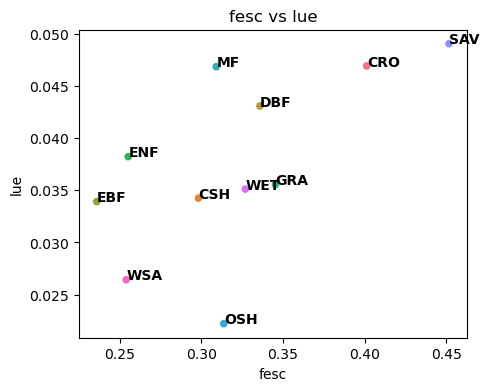

In [408]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

x = "fesc"
y = "lue"

df_to_plot = max_values_grouped

scatter = sns.scatterplot(data=df_to_plot, x=x, y=y, hue="site_type", ax=ax)
for line in range(0, df_to_plot.shape[0]):
    scatter.text(
        df_to_plot[x][line] + 0.0001,
        df_to_plot[y][line],
        df_to_plot.index[line],
        horizontalalignment="left",
        size="medium",
        color="black",
        weight="semibold",
    )

ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(x + " vs " + y)
scatter.legend_.remove()
plt.savefig("../outputs/figures/lue_fec.png")

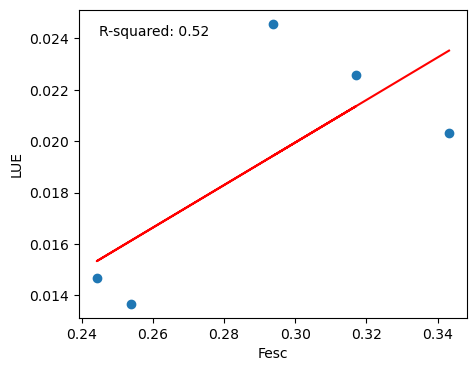

In [398]:
# Filter data
df_to_plot = median_values

closed_pft = df_to_plot[df_to_plot["site_type"] == "CSH"]
# Define x and y
x = closed_pft["fesc"].values.reshape(-1, 1)  # Reshape needed for the model fit
y = closed_pft["lue"].values

# Create scatter plot
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(x, y)

# Fit a linear regression model
model = LinearRegression().fit(x, y)

# Get the R-squared value
r2 = model.score(x, y)
y_pred = model.predict(x)

# Plot the fitted line
plt.plot(x, y_pred, color="red")

# Show R-squared on the plot
plt.text(
    0.05, 0.95, f"R-squared: {r2:.2f}", transform=ax.transAxes, verticalalignment="top"
)
plt.xlabel("Fesc")
plt.ylabel("LUE")
plt.show()

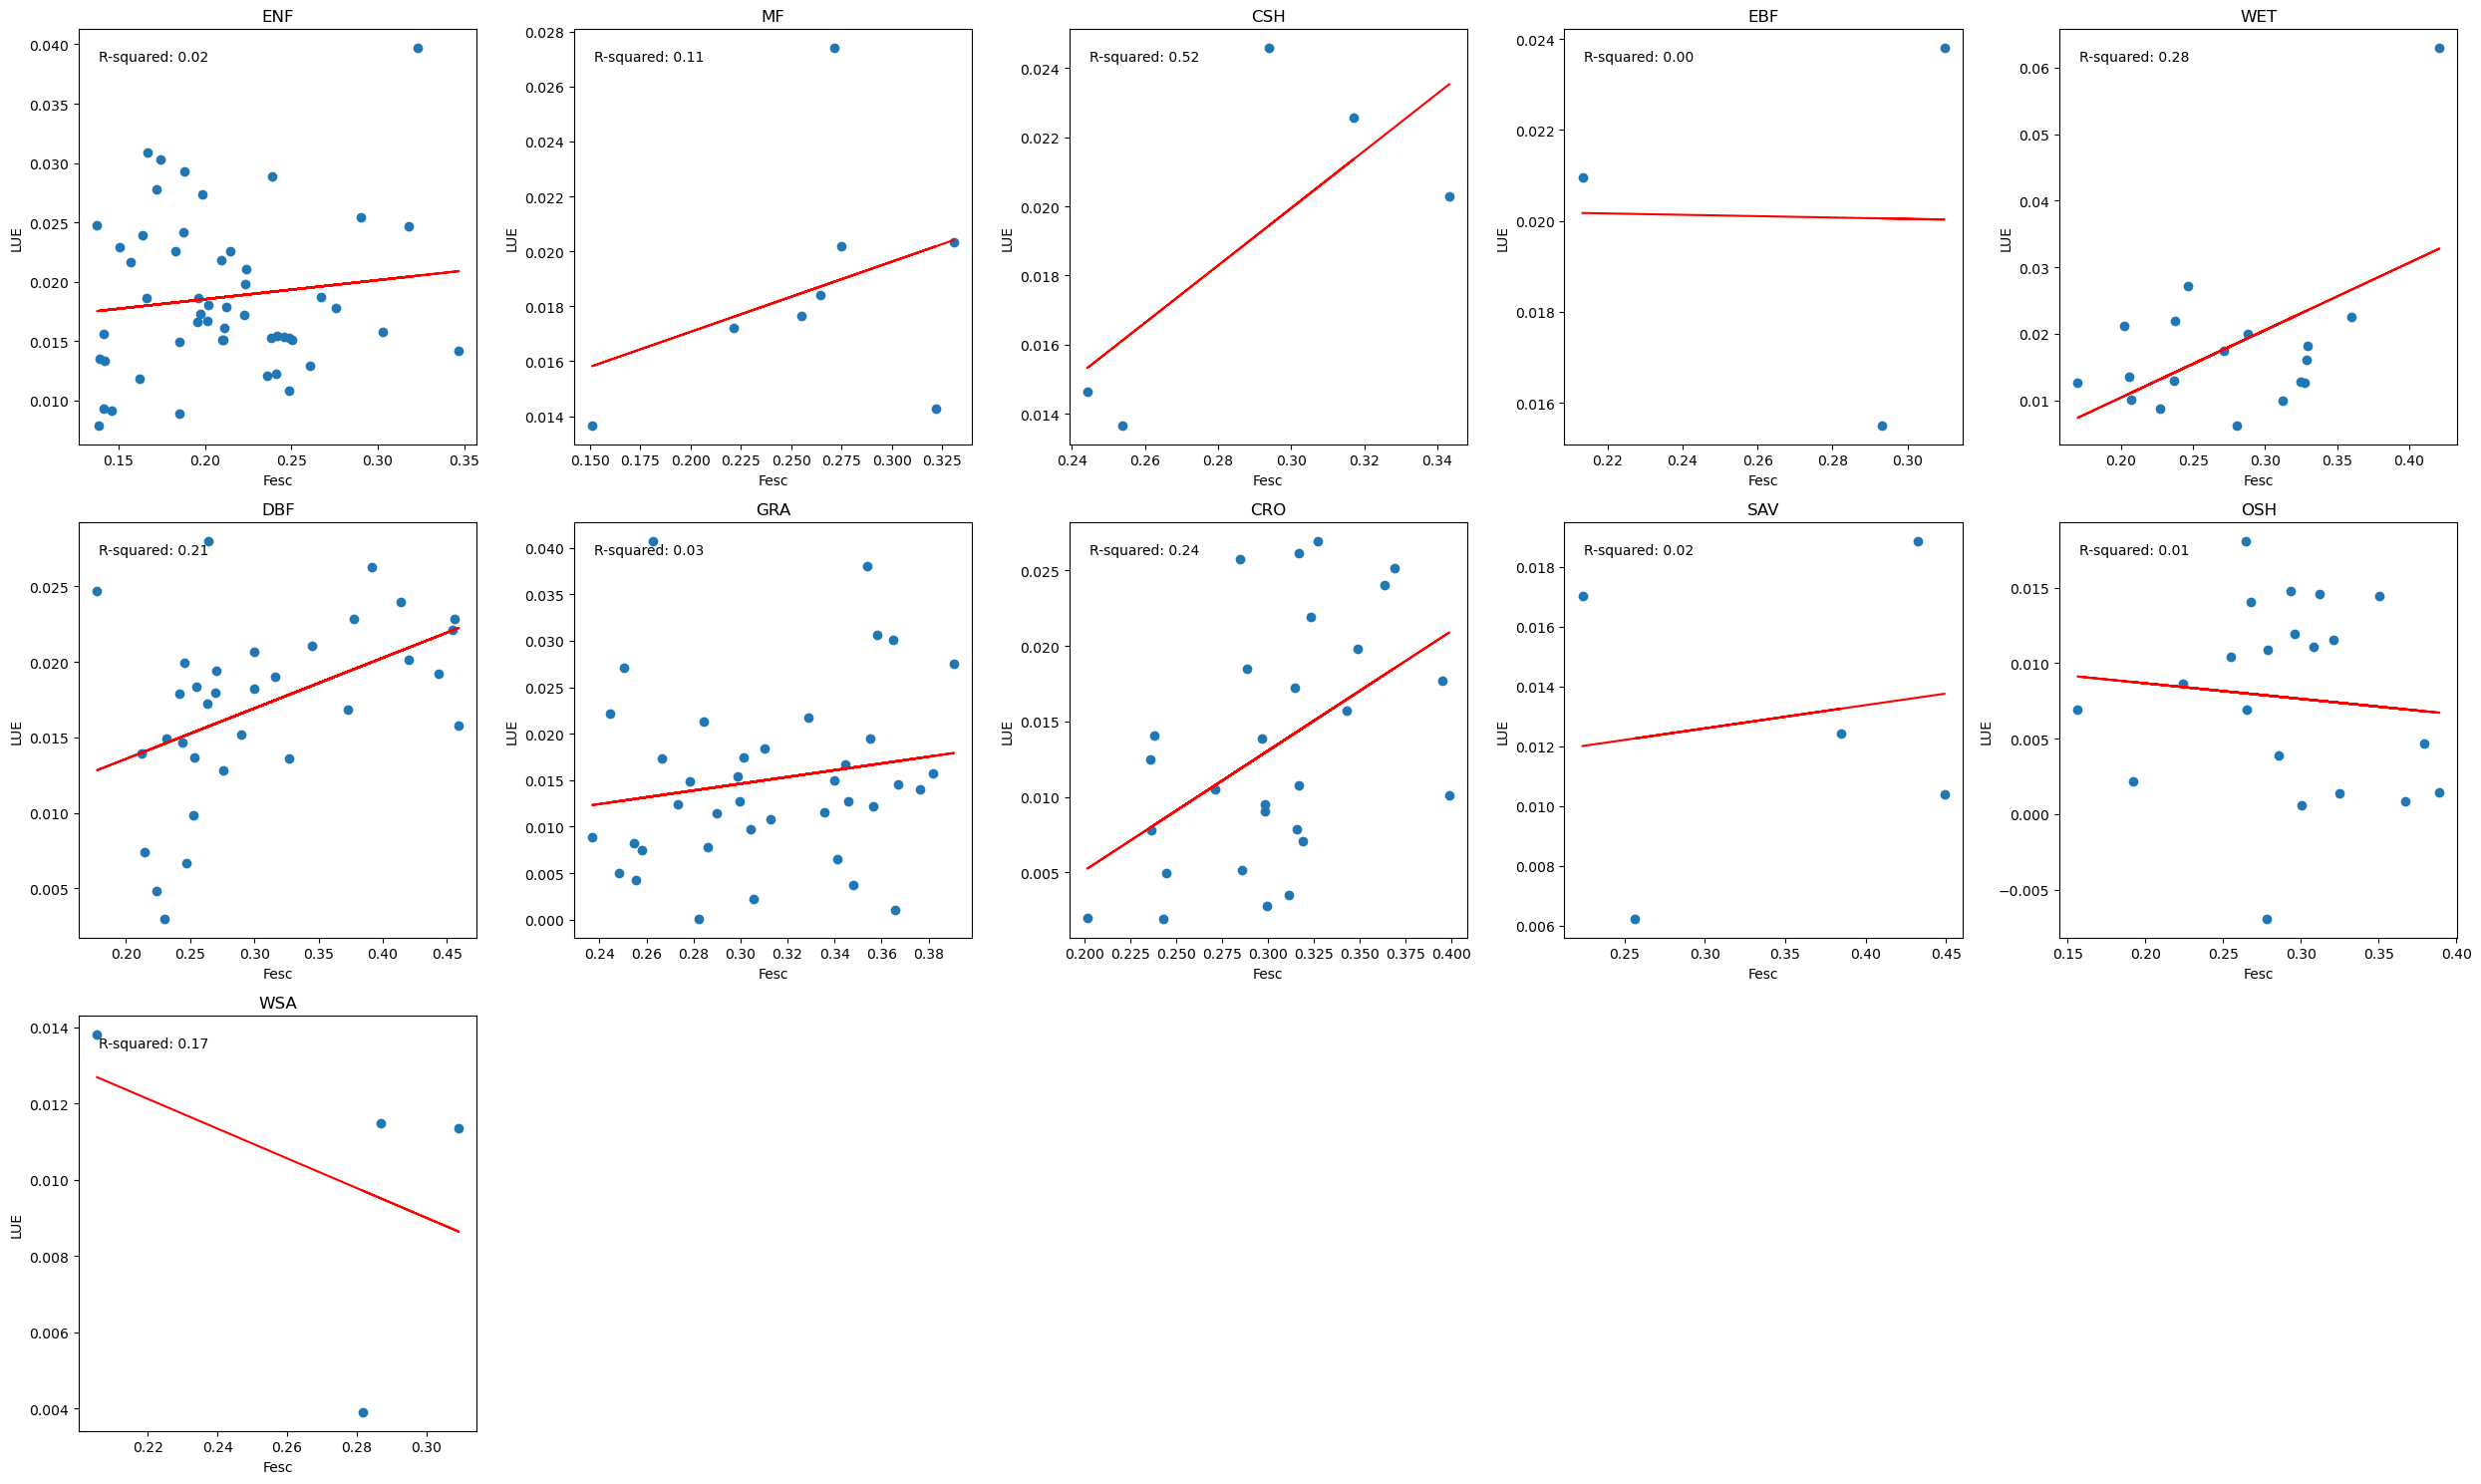

In [404]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Filter data
df_to_plot = median_values

# Get unique site types
site_types = ["ENF","MF","CSH","EBF","WET","DBF","GRA","CRO","SAV","OSH","WSA"]

# Create a subplot for each site type
fig, axs = plt.subplots(3, 5, figsize=(25, 15))  # 3 rows, 5 columns

axs = axs.flatten()  # Flatten the array of axes to make it easier to iterate over

for i, (ax, site_type) in enumerate(zip(axs, site_types)):
    # Filter data for the current site type
    site_data = df_to_plot[df_to_plot["site_type"] == site_type]

    # Define x and y
    x = site_data["fesc"].values.reshape(-1, 1)  # Reshape needed for the model fit
    y = site_data["lue"].values

    # Create scatter plot
    ax.scatter(x, y)

    # Fit a linear regression model
    model = LinearRegression().fit(x, y)

    # Get the R-squared value
    r2 = model.score(x, y)
    y_pred = model.predict(x)

    # Plot the fitted line
    ax.plot(x, y_pred, color="red")

    # Show R-squared on the plot
    ax.text(
        0.05, 0.95, f"R-squared: {r2:.2f}", transform=ax.transAxes, verticalalignment="top"
    )
    ax.set_xlabel("Fesc")
    ax.set_ylabel("LUE")
    ax.set_title(site_type)

# Remove the extra subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig("../outputs/figures/within_median.png")

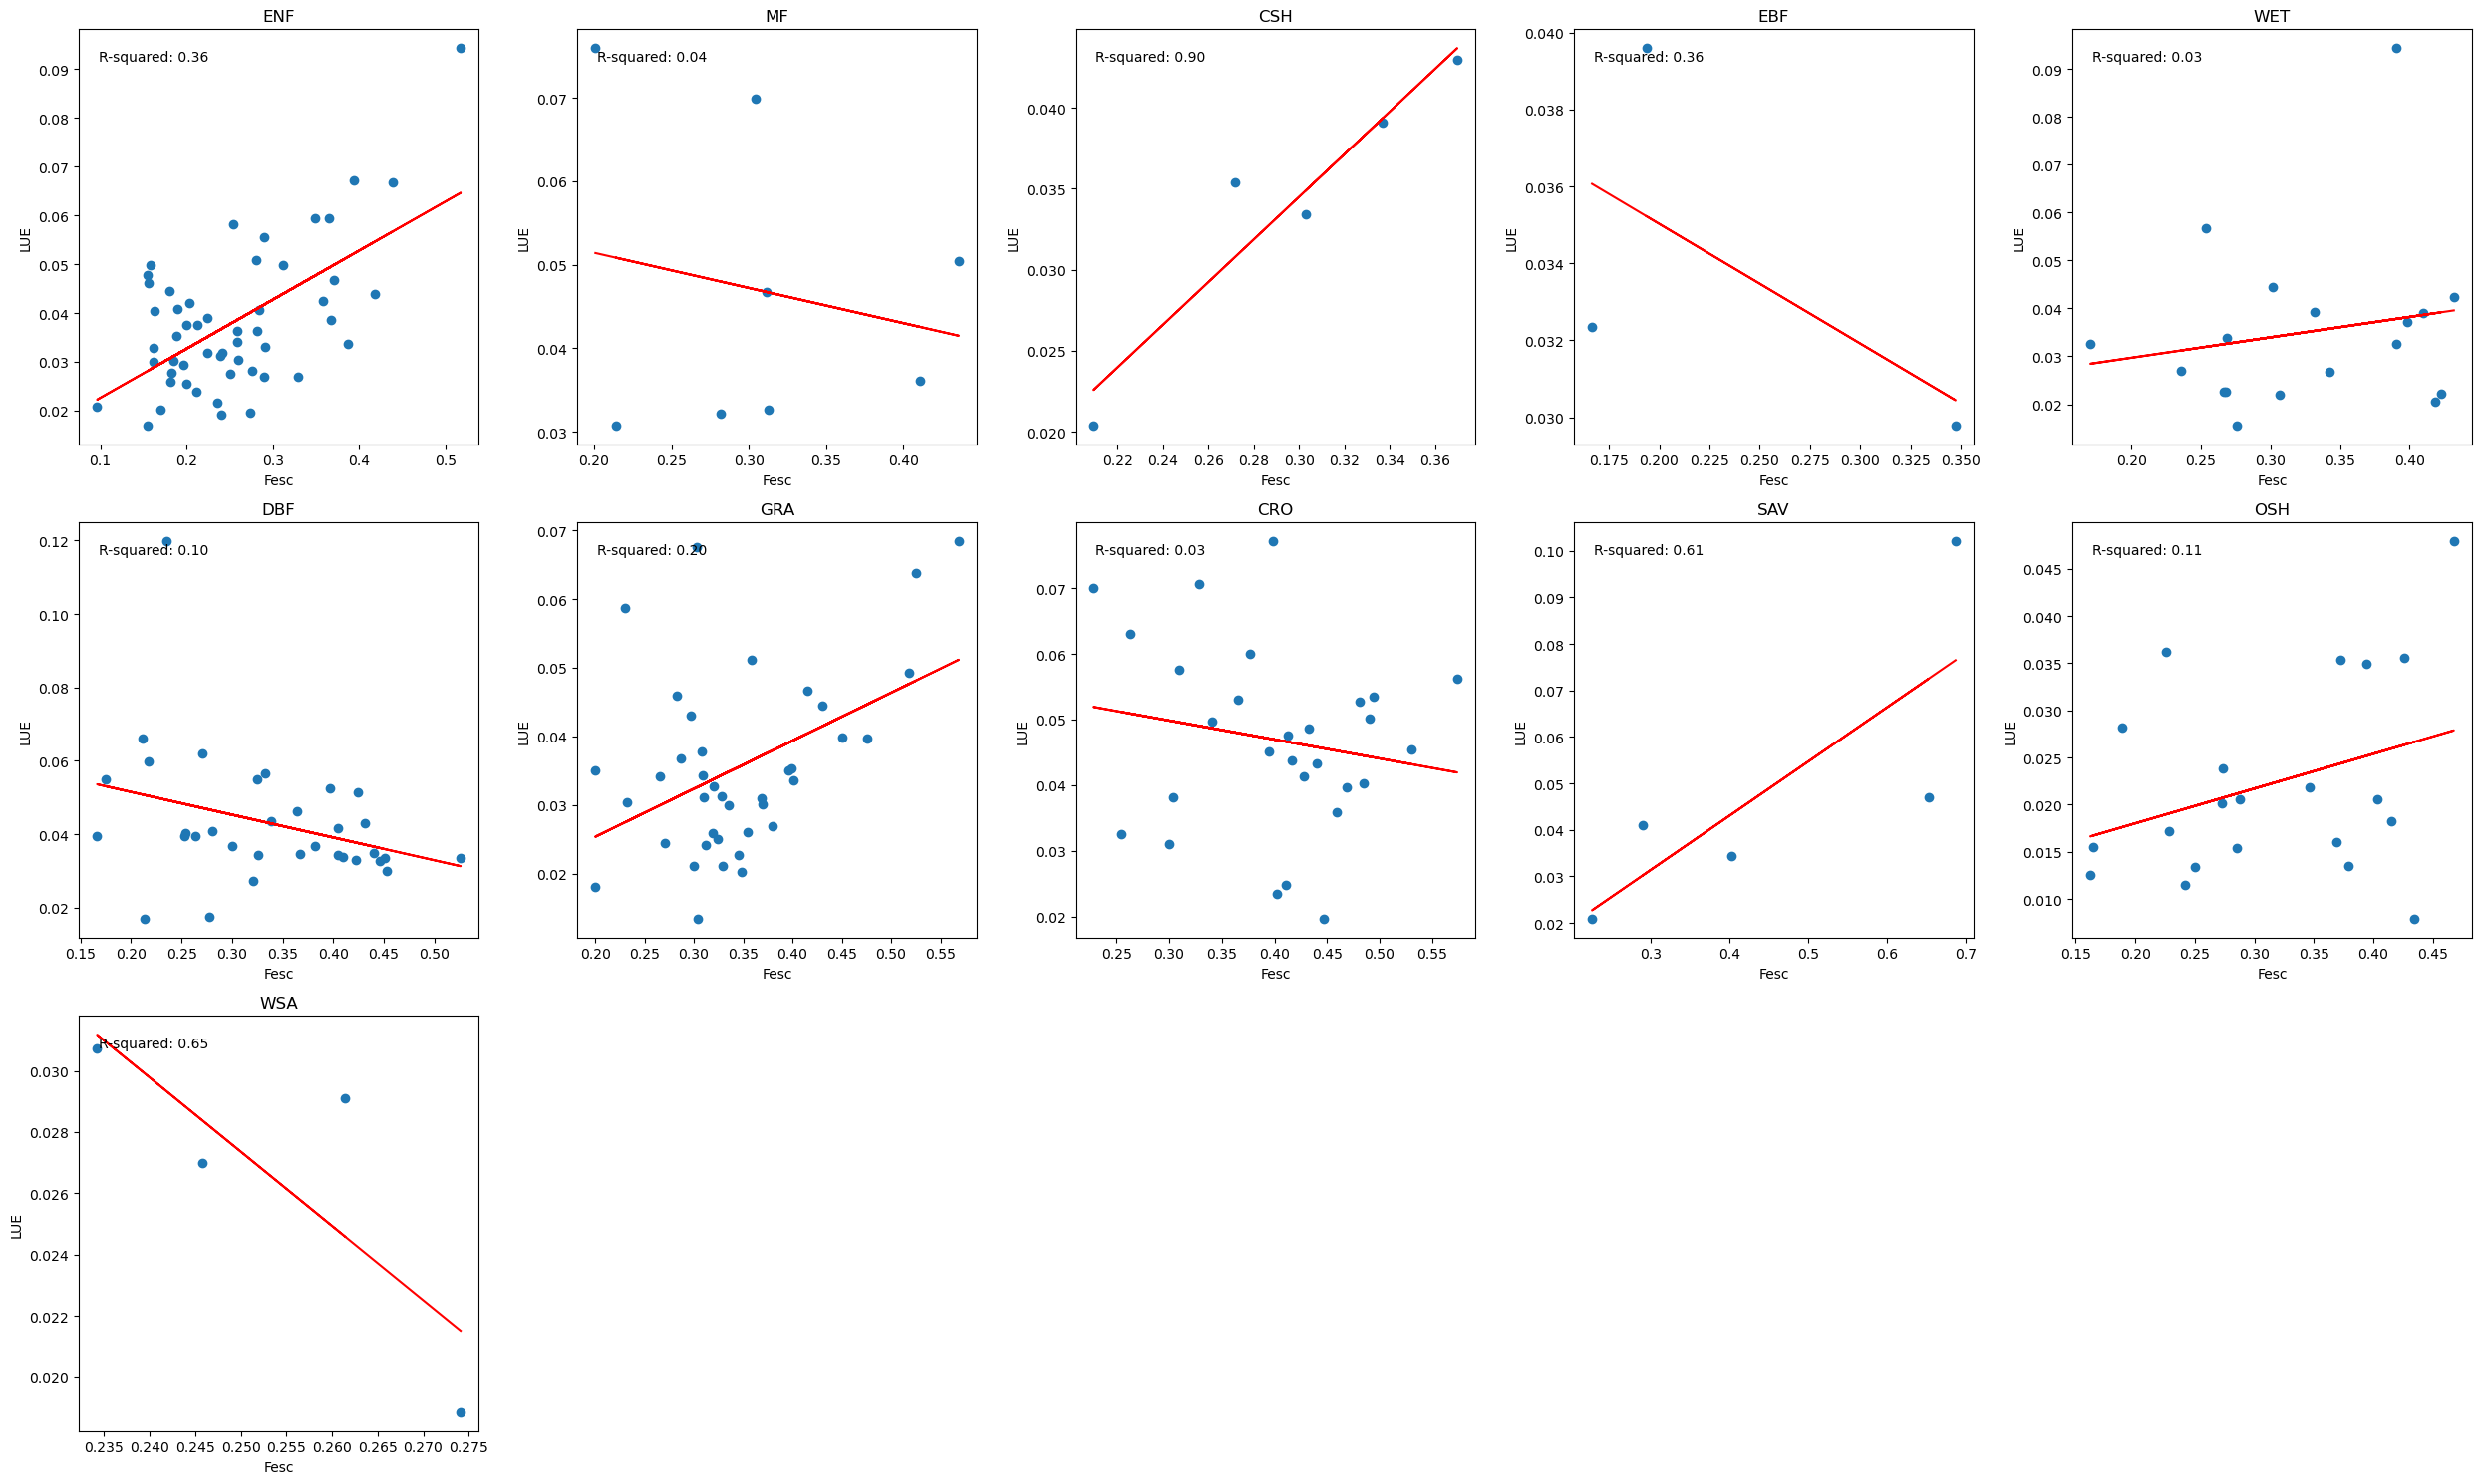

In [405]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Filter data
df_to_plot = max_values

# Get unique site types
# site_types = df_to_plot["site_type"].unique()
site_types = ["ENF","MF","CSH","EBF","WET","DBF","GRA","CRO","SAV","OSH","WSA"]

# Create a subplot for each site type
fig, axs = plt.subplots(3, 5, figsize=(25, 15))  # 3 rows, 5 columns

axs = axs.flatten()  # Flatten the array of axes to make it easier to iterate over

for i, (ax, site_type) in enumerate(zip(axs, site_types)):
    # Filter data for the current site type
    site_data = df_to_plot[df_to_plot["site_type"] == site_type]

    # Define x and y
    x = site_data["fesc"].values.reshape(-1, 1)  # Reshape needed for the model fit
    y = site_data["lue"].values

    # Create scatter plot
    ax.scatter(x, y)

    # Fit a linear regression model
    model = LinearRegression().fit(x, y)

    # Get the R-squared value
    r2 = model.score(x, y)
    y_pred = model.predict(x)

    # Plot the fitted line
    ax.plot(x, y_pred, color="red")

    # Show R-squared on the plot
    ax.text(
        0.05, 0.95, f"R-squared: {r2:.2f}", transform=ax.transAxes, verticalalignment="top"
    )
    ax.set_xlabel("Fesc")
    ax.set_ylabel("LUE")
    ax.set_title(site_type)

# Remove the extra subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig("../outputs/figures/within_max.png")